<a href="https://colab.research.google.com/github/seawavve/PeekABook/blob/main/model/custom_bert_final2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
! pip install -q tensorflow-text
! pip install -q tf-models-official
! pip install tensorflow==2.4.0
! pip install tensorflow-gpu==2.4.0

     |████████████████████████████████| 3.4MB 4.3MB/s 
     |████████████████████████████████| 1.6MB 4.1MB/s 
     |████████████████████████████████| 686kB 36.4MB/s 
     |████████████████████████████████| 645kB 36.0MB/s 
     |████████████████████████████████| 38.2MB 76kB/s 
     |████████████████████████████████| 358kB 25.5MB/s 
     |████████████████████████████████| 174kB 44.1MB/s 
     |████████████████████████████████| 102kB 10.1MB/s 
     |████████████████████████████████| 1.2MB 29.7MB/s 
     |████████████████████████████████| 454.3MB 41kB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
     |████████████████████████████████| 51kB 6.7MB/s 
     |████████████████████████████████| 471kB 31.8MB/s 
     |████████████████████████████████| 4.0MB 29.7MB/s 
     |████████████████████████████████| 1.2MB 34.6MB/s 
     |████████████████████████████████| 4.0MB 31.9MB/s 
     |████████████████████████████████| 6.0MB 30.7MB/s 
     |████████████████████████████████| 4.9MB 34.9MB/s 

In [2]:
import os, sys 
from google.colab import drive 
drive.mount('/content/mnt') 
nb_path = '/content/notebooks' 
os.symlink('/content/mnt/My Drive/Colab Notebooks', nb_path) 
sys.path.insert(0, nb_path)


Mounted at /content/mnt


In [3]:
import os
import shutil
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
#@title Configure the model { run: "auto" }
BERT_MODEL = "https://tfhub.dev/google/experts/bert/wiki_books/sst2/2"
# Preprocessing must match the model, but all the above use the same.
PREPROCESS_MODEL = hub.load('https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3')

In [5]:
# data=pd.read_csv('./Peterpan_emo3.csv')
# data=data.dropna(how='any')
# print(f'Dimensions: {data.shape}')
# data

In [6]:
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 1
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Junglebook_data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Junglebook_data/train',
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    'mnt/MyDrive/Junglebook_data/test',
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 3189 files belonging to 3 classes.
Using 2552 files for training.
Found 3189 files belonging to 3 classes.
Using 637 files for validation.
Found 60 files belonging to 3 classes.


In [7]:
for text_batch, label_batch in train_ds.take(3):
  print(f'Review: {text_batch.numpy()[0]}')
  label = label_batch.numpy()[0]
  print(f'Label : {label} ({class_names[label]})')
  text_test = [text_batch.numpy()[0]]
  text_preprocessed = PREPROCESS_MODEL(text_test)
  print(f'Keys       : {list(text_preprocessed.keys())}')
  print(f'Shape      : {text_preprocessed["input_word_ids"].shape}')
  print(f'Word Ids   : {text_preprocessed["input_word_ids"][0, :12]}')
  print(f'Input Mask : {text_preprocessed["input_mask"][0, :12]}')
  print(f'Type Ids   : {text_preprocessed["input_type_ids"][0, :12]}\n')
  


Review: b'Arre.'
Label : 0 (Mod)
Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101 12098  2890  1012   102     0     0     0     0     0     0     0]
Input Mask : [1 1 1 1 1 0 0 0 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b"Mowgli, who naturally knew something about what they were talking of, had to cover his face not to show that he was laughing, while Buldeo, the Tower musket across his knees, climbed on from one wonderful story to another, and Mowgli's shoulders shook."
Label : 0 (Mod)
Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  9587 27767  3669  1010  2040  8100  2354  2242  2055  2054  2027]
Input Mask : [1 1 1 1 1 1 1 1 1 1 1 1]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]

Review: b'Who speaks for this cub.'
Label : 0 (Mod)


Keys       : ['input_mask', 'input_type_ids', 'input_word_ids']
Shape      : (1, 128)
Word Ids   : [  101  2040  8847  2005  2023 21987  1012   102     0     0     0     0]
Input Mask : [1 1 1 1 1 1 1 1 0 0 0 0]
Type Ids   : [0 0 0 0 0 0 0 0 0 0 0 0]



# BERT

In [8]:
from tensorflow.keras import layers

def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(PREPROCESS_MODEL, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(BERT_MODEL, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']

  net = tf.keras.layers.Dropout(0.1)(net)
  #net = tf.keras.layers.Dense(64, activation='relu')(net)
  net = tf.keras.layers.Dense(3, activation='sigmoid', name='classifier')(net)
  return tf.keras.Model(text_input, net)

In [9]:
# classifier_model = build_classifier_model()
# bert_raw_result = classifier_model(tf.constant(text_test))
# print(tf.sigmoid(bert_raw_result))

In [10]:
text_test = ['this is such an amazing movie!']
classifier_model = build_classifier_model()
bert_raw_result = classifier_model(tf.constant(text_test))
print(tf.sigmoid(bert_raw_result))

tf.Tensor([[0.60601526 0.6002927  0.6763452 ]], shape=(1, 3), dtype=float32)


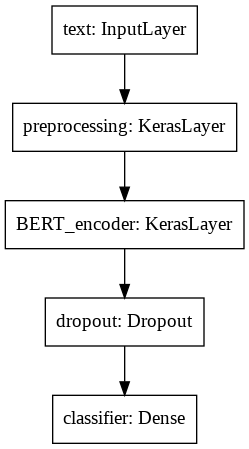

In [11]:
tf.keras.utils.plot_model(classifier_model)

In [12]:
! pip install -q tf-models-official
from official.nlp import optimization

ERROR: tensorflow-text 2.4.3 has requirement tensorflow<2.5,>=2.4.0, but you'll have tensorflow 2.5.0 which is incompatible.
ERROR: tensorflow-gpu 2.4.0 has requirement gast==0.3.3, but you'll have gast 0.4.0 which is incompatible.
ERROR: tensorflow-gpu 2.4.0 has requirement grpcio~=1.32.0, but you'll have grpcio 1.34.1 which is incompatible.
ERROR: tensorflow-gpu 2.4.0 has requirement h5py~=2.10.0, but you'll have h5py 3.1.0 which is incompatible.
ERROR: tensorflow-gpu 2.4.0 has requirement tensorflow-estimator<2.5.0,>=2.4.0rc0, but you'll have tensorflow-estimator 2.5.0 which is incompatible.


In [13]:
loss = tf.keras.losses.SparseCategoricalCrossentropy()
metric = tf.keras.metrics.SparseCategoricalAccuracy()
epochs = 20
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')


In [14]:
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metric)

In [15]:
print(f'Training model with {BERT_MODEL}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs)

Training model with https://tfhub.dev/google/experts/bert/wiki_books/sst2/2
Epoch 1/20
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2552/2552 [==============================] - ETA: 0s - loss: 1.2397 - sparse_categorical_accuracy: 0.6562WARNING:tensorflow:AutoGraph could not transform <function Model.make_test_function.<locals>.test_function at 0x7f65823d7950> and will run it as-is.
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert


Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: closure mismatch, requested ('self', 'step_function'), but source function had ()
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
2552/2552 [==============================] - 1608s 623ms/step - loss: 1.2397 - sparse_categorical_accuracy: 0.6562 - val_loss: 1.2996 - val_sparse_categorical_accuracy: 0.7834
Epoch 2/20
2552/2552 [==============================] - 445s 175ms/step - loss: 1.1165 - sparse_categorical_accuracy: 0.7918 - val_loss: 1.6629 - val_sparse_categorical_accuracy: 0.7504
Epoch 3/20
2552/2552 [==============================] - 446s 175ms/step - loss: 0.7831 - sparse_categorical_accuracy: 0.8776 - val_loss: 1.8321 - val_sparse_categorical_accuracy: 0.7645
Epoch 4/20
2552/2552 [==============================] - 445s 175ms/step - loss: 0.4802 - sparse_categorical_a

In [16]:
loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

60/60 [==============================] - 33s 479ms/step - loss: 4.8743 - sparse_categorical_accuracy: 0.6333
Loss: 4.8742570877075195
Accuracy: 0.6333333253860474


dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


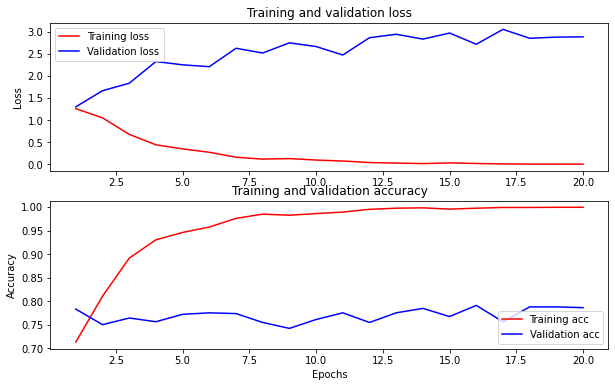

In [18]:
history_dict = history.history
print(history_dict.keys())

acc = history_dict['sparse_categorical_accuracy']
val_acc = history_dict['val_sparse_categorical_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# "bo" is for "blue dot"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [ ]:
from sklearn.model_selection import GridSearchCV

params = {'epochs':[10,20,30], 'learning_rate':[2e-5, 3e-5, 5e-5]}
grid = GridSearchCV(estimator=classifier_model, param_grid=params, scoring='sparse_categorical_accuracy', n_jobs=-1, cv=3)
grid_result = grid.fit(X, Y)

# fit gridsearch 
clf.fit(X_train ,y_train)